# "[ML] KNN2"
> "타이타닉 데이터셋 최근접 이웃 분류"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [KNN,Titanic]
- author: 도형준

# 라이브러리 및 데이터 적재

In [8]:
#@title 필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#@title 데이터 불러오기
file_url = "https://raw.githubusercontent.com/bigdata-young/bigdata_16th/main/data/"
train = pd.read_csv(f'{file_url}/titanic_train.csv', index_col=0)

In [10]:
train.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# 기초 통계 살펴보기

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [12]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
train.isnull().sum()
# Cabin은 drop예정
# Age는 평균값으로 대체

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [15]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 데이터 전처리 및 이상치 확인

In [16]:
# 수업시간에 쓴 전처리 코드를 그대로 가져왔습니다.
def pre_processing(df : pd.DataFrame):
    df.Embarked = df.Embarked.fillna("S")
    df.Fare = df.Fare.fillna(0)
    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')
    rarelist = [a for a in set(df['Title'])
                if list(df['Title']).count(a) < 10]
    df['Title'] = df['Title'].replace(rarelist, 'Rare')
    title_age_mean = df.groupby(['Title'])['Age'].mean()
    for v in df['Title'].unique():
        df.loc[df.Age.isnull() & (df.Title == v), 'Age'] = title_age_mean[v]
    df_clean = df.drop(columns=['Name', 'Ticket', 'Title', 'Cabin'])
    return pd.get_dummies(df_clean,
                          columns = ['Sex', 'Embarked'], drop_first=True)

In [17]:
df_train = pre_processing(train)
df_train.tail()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
887,0,2,27.000000,0,0,13.00,1,0,1
888,1,1,19.000000,0,0,30.00,0,0,1
889,0,3,21.773973,1,2,23.45,0,0,1
890,1,1,26.000000,0,0,30.00,1,0,0
891,0,3,32.000000,0,0,7.75,1,1,0


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    uint8  
 7   Embarked_Q  891 non-null    uint8  
 8   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 51.3 KB


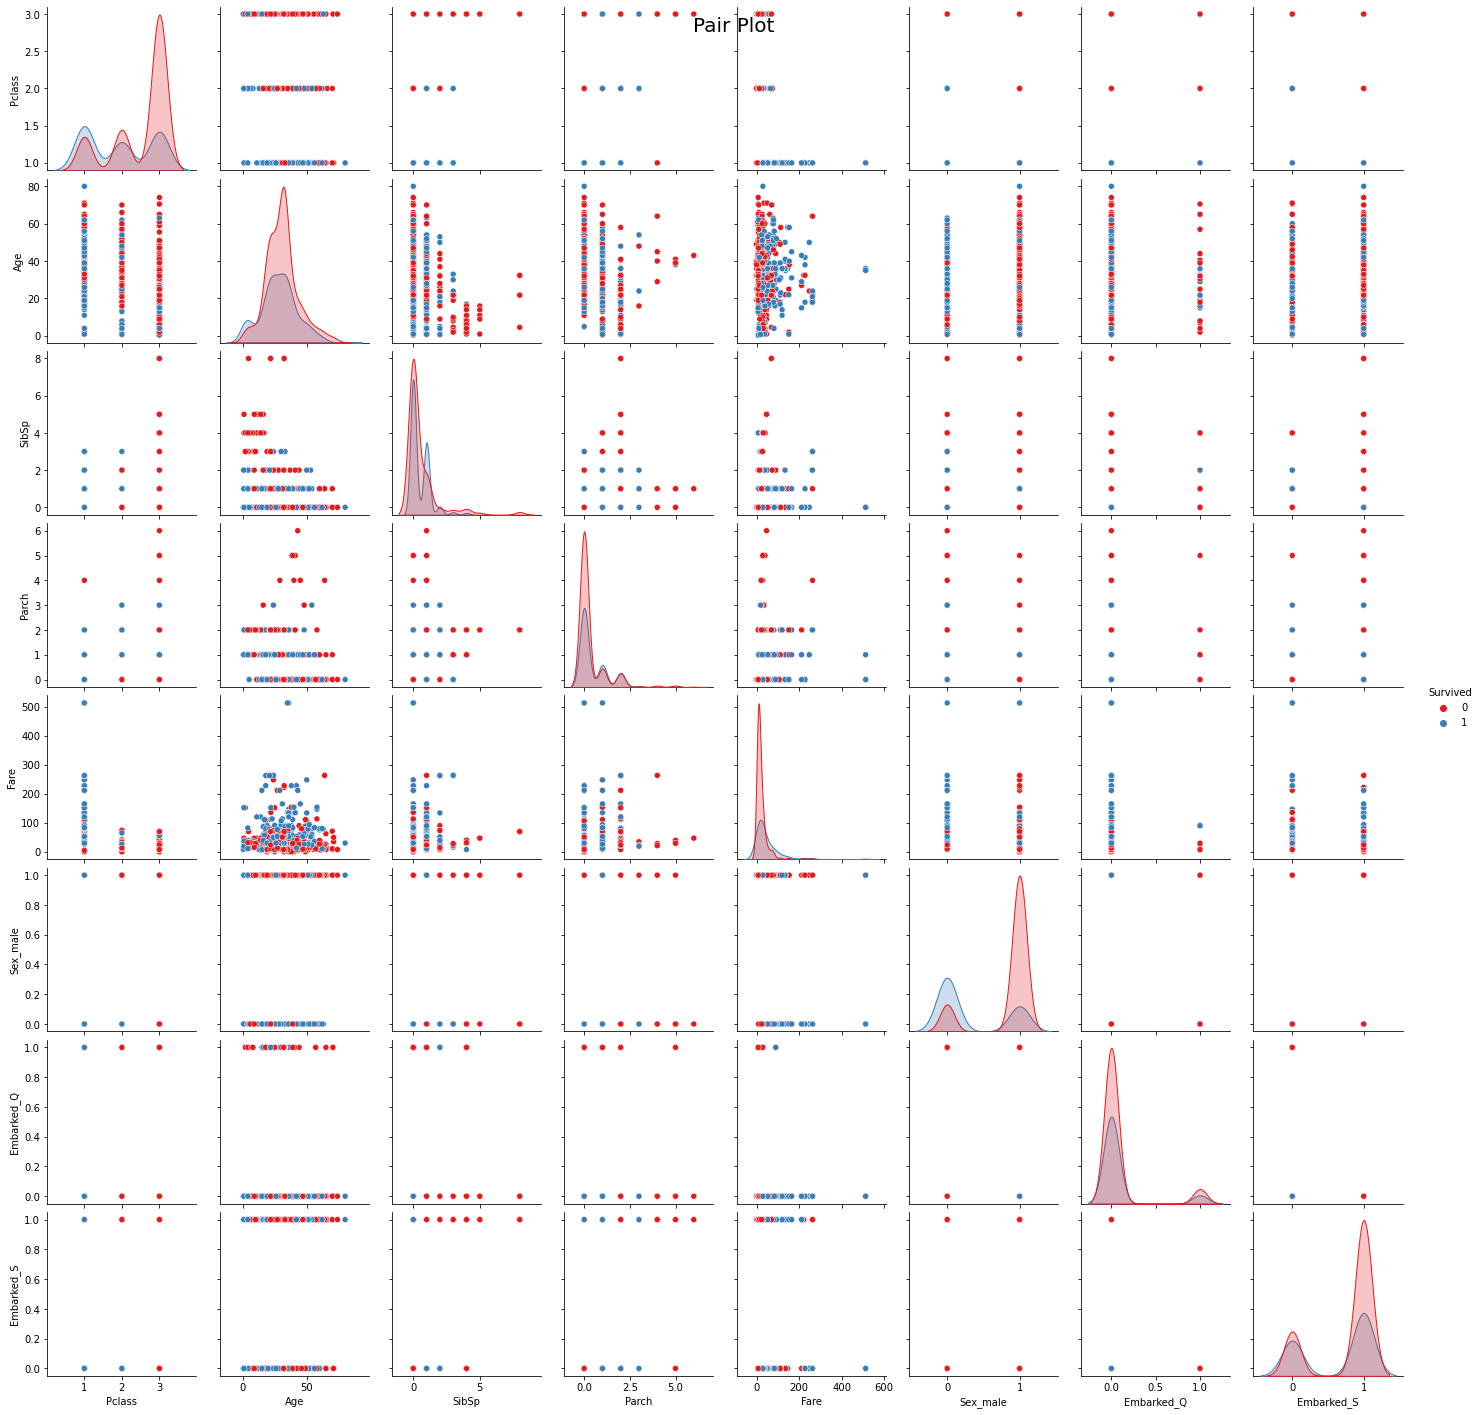

In [19]:
sns.pairplot(data=df_train,hue="Survived",palette="Set1")
plt.suptitle("Pair Plot",fontsize=20)
plt.show()

In [ ]:
#@title df_train.describe()
def outlier_iqr(data, column): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    #print('IQR은',iqr, '이다.')     
    #print('lower bound 값은', lower, '이다.')     
    #print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')

In [ ]:
df_train_columns = list(df_train.columns)

for i in df_train_columns:
  print(i)
  outlier_iqr(df_train,i)
  print('\n')

In [ ]:
#@title 그냥 궁금해서 보는 상관계수
df_train_corr=df_train.corr()
df_train_corr

In [ ]:
# 모두가 같은 전처리 방식을 했다는 가정하에
import plotly.express as px
fig = px.imshow(df_train_corr,text_auto=True, color_continuous_scale='RdBu_r',title='상관관계 히트맵')
fig.show()
''' 현재 컬럼들 중 성별이 생존률에 가장 큰 영향을 미쳤음을 알 수 있음(가장 진한 부분) --> 여성일수록 생존률이 높다
하지만 상관계수가 약 0.55로 그렇게 유의미하지 않은 케이스라 피처 엔지니어링을 통해 컬럼을 다시 살펴볼 필요가 있을 것 같음.

참고로 저번 강사님께서 말씀하셨듯이 나이도 구간을 나눌 경우 유의미하지 않았다는 점을 고려해볼 수 있음
그렇기에 나이도 np.percentile이나 다른 방식으로 구간을 나눠서 볼 필요가 있을 것 같음
유의미한 나이대 구간이 존재하지 않을까 생각해봄...'''
''' 상식적으로 노약자의 생존률이 높을 것 같은데
나이의 상관계수가 너무 낮게 나와서 좀 당황한 기억이 있어서, 다들 살펴보면 좋을 것 같습니다!'''

https://github.com/dorae222/personal_study/blob/main/pyhon_numpy_pandas_visual/python_da/Pandas/2022-11-02-%5BDA%5D%20%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb <br>
<연령대별 생존 비율> 참고<br>
상관계수 결론: 기사도 정신은 없었던 것 같다.

# 데이터셋 분리

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop('Survived', axis=1),
    df_train.Survived, test_size=0.2, random_state=100
)

In [ ]:
X_test

In [ ]:
min(X_test['Fare'])

# 스케일러, KNN파라미터 튜닝 함수로 정의

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [ ]:
np.array([3, 5, 2, 3, 3, 1, 1,0]).reshape(1, -1)

In [ ]:
print(st_scaler)

In [ ]:
#@title 각 스케일러 함수로 정의
def minmax(a,b) :
  mm_scaler = MinMaxScaler()
  X_train_scaled = mm_scaler.fit_transform(a)
  X_test_scaled = mm_scaler.transform(b)
  return X_train_scaled, X_test_scaled

def robust(a,b) :
  rb_scaler = RobustScaler()
  X_train_scaled = rb_scaler.fit_transform(a)
  X_test_scaled = rb_scaler.transform(b)
  return X_train_scaled, X_test_scaled


def standard(a,b) :
  st_scaler = StandardScaler()
  X_train_scaled = st_scaler.fit_transform(a)
  X_test_scaled = st_scaler.transform(b)
  return X_train_scaled, X_test_scaled

In [ ]:
#@title KNN을 위한 라이브러리리
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#@title KNN을 위한 함수 정의
def tuning(n):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled, y_train)
    pred = knn.predict(X_test_scaled)
    score = accuracy_score(y_test, pred)
    return score

In [ ]:
import pickle

st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)
X_test_scaled = st_scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)

In [ ]:
joblib.dump(knn,'knn_model.pkl')

In [ ]:
joblib.dump(StandardScaler,'st_scaler.pkl')

# 스케일러 별로 KNN 최종 스코어 구하기

In [ ]:
#@title  MinMax 스케일링 시
X_train_scaled, X_test_scaled = minmax(X_train,X_test)
scores = [(i, tuning(i)) for i in range(1, 21)]
scores=sorted(scores, key=lambda x: x[1], reverse=True)
Minmax_k_num = scores[0][0]

for i in range(20):
  score_sum=scores[i][1]
MinMax_score_mean = score_sum/20
MinMax_score_max = scores[0][1]
print('MinMax_score_mean:', MinMax_score_mean)
print('MinMax_score_max:', MinMax_score_max)
print('Minmax 인접한 이웃의 수: ',Minmax_k_num )

In [ ]:
#@title  Standard 스케일링 시
X_train_scaled, X_test_scaled = standard(X_train,X_test)
scores = [(i, tuning(i)) for i in range(1, 21)]
scores=sorted(scores, key=lambda x: x[1], reverse=True)
Standard_k_num = scores[0][0]

for i in range(20):
  score_sum=scores[i][1]

Standard_score_mean = score_sum/20
Standard_score_max = scores[0][1]
print('Standard_score_mean:', Standard_score_mean)
print('Standard_score_max:', Standard_score_max)
print('Standard 인접한 이웃의 수: ', Standard_k_num)

In [ ]:
#@title  Robust 스케일링 시
X_train_scaled, X_test_scaled = robust(X_train,X_test)
scores = [(i, tuning(i)) for i in range(1, 21)]
scores=sorted(scores, key=lambda x: x[1], reverse=True)
Robust_k_num = scores[0][0]

for i in range(20):
  score_sum=scores[i][1]

Robust_score_mean = score_sum/20
Robust_score_max = scores[0][1]
print('Robust_score_mean:', Robust_score_mean)
print('Robust_score_max:', Robust_score_max)
print('Robust 인접한 이웃의 수: ', Robust_k_num)

In [ ]:
#@title  스케일러 종합하여 비교하기
print('스케일러별 평균 점수')
print('MinMax_score_mean:', MinMax_score_mean)
print('Robust_score_mean:', Robust_score_mean)
print('Standard_score_mean:', Standard_score_mean,'\n')

print('스케일러별 최대 점수')
print('MinMax_score_max:', MinMax_score_max)
print('Robust_score_max:', Robust_score_max)
print('Standard_score_max:', Standard_score_max,'\n')

print('스케일러별 인접한 이웃의 개수')
print('Minmax 인접한 이웃의 수: ',Minmax_k_num )
print('Robust 인접한 이웃의 수: ', Robust_k_num)
print('Standard 인접한 이웃의 수: ', Standard_k_num)

# 결론
{Standard_score_max: 0.8435754189944135이므로} Standard Scaler가 성능이 가장 좋음을 알 수 있다.<br>
하지만 대체적으로 성능에서는 크게 차이가 나지 않는다<br>
이는 애초에 이상치가 대체로 적기 때문에, 스케일러의 영향이 적어 스코어 차이가 적은 것으로 예상해 볼 수 있다.<br>

In [ ]:
import joblib
import numpy as np
model = joblib.load('knn_model.pkl')

pred = model.predict(variable)

In [ ]:
pred